<a href="https://colab.research.google.com/github/GabrielFRodrigues96/PNL_INFNET/blob/main/GABRIELRODRIGUES_PROCESSAMENTOLINGUAGEMNATURAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Disciplina de Processamento de Linguagem Natural com Python

Bem-vindo ao projeto de disciplina de **Processamento de Linguagem Natural com Python**. Ao longo das últimas aulas vimos uma série de aplicações que nos deram a amplitude de possibilidades em trabalhar com textos. Para tal, usamos diversas bibliotecas, onde as que mais se destacaram foram NLTK, SPACY e GENSIM.

Esse notebook servirá de guia para a execução de uma análise de tópicos completa, usando o algoritmo de LDA e recursos para interpretação dos resultados. Utilizaremos notícias da seção "Mercado" extraídas da Folha de S. Paulo no ano de 2016.  Complete a análise com os códigos que achar pertinente e responda as questões presentes no Moodle. Boa sorte!

## O Notebook

Nesse notebook, você será guiado pela análise de **Extração de Tópicos**. As seguintes tarefas serão realizadas


1.   Download dos dados provenientes do kaggle 
2.   Seleção dos dados relevantes para a nossa análise
3.   Instalação das principais ferramentas e importação de módulos
4.   Pré-processamento usando NLTK
5.   Pré-processamento usando Spacy
6.   Análise de tópicos usando LDA
7.   Análise de NER usando Spacy
8.   Visualização dos tópicos usando tokens e entidades.



## Instruções para baixar os dados

Para baixar os dados será necessário o uso do gerenciador de downloads da Kaggle. A Kaggle, uma subsidiária do grupo Alphabet (Google), é uma comunidade on-line de cientistas de dados e profissionais de aprendizado de máquina.

Para utilizar o gerenciador, será necessário criar uma conta no site Kaggle.com.
Com a conta criada, obtenha um token de acesso, no formato kaggle.json

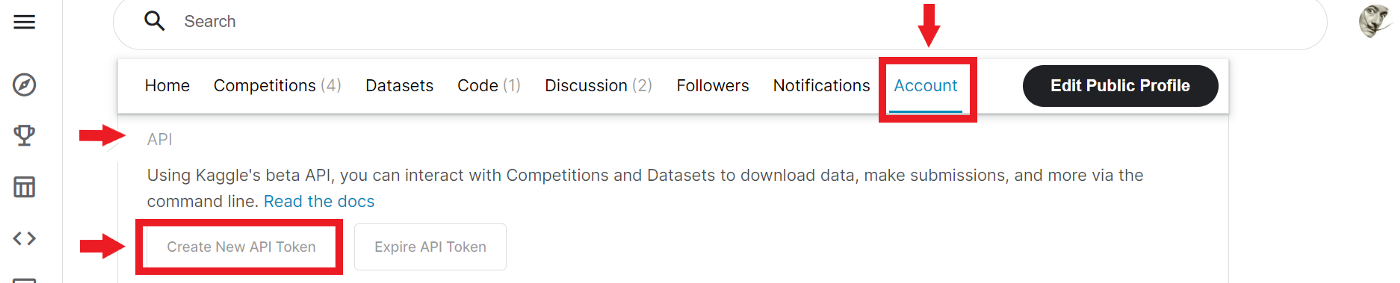

Em posse do token (baixe para seu computador), execute a células da próxima seção para acessar os dados de interesse e baixá-los.

# Baixe os dados

Instale o gerenciador kaggle no ambiente do Colab e faça o upload do arquivo kaggle.json 

In [ ]:
!pip install -q kaggle
!rm -rf kaggle.json
from google.colab import files

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabrielfrodrigues","key":"ef7001691cbdea8f47bbbd5aa0bf4d34"}'}

Crie a pasta .kaggle

In [ ]:
!pip install -q kaggle
!rm -rf .kaggle
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Baixe o dataset

In [ ]:
!kaggle datasets download --force -d marlesson/news-of-the-site-folhauol

 99% 186M/187M [00:05<00:00, 43.5MB/s]
100% 187M/187M [00:05<00:00, 37.3MB/s]


## Criar o DataFrame com os dados lidos diretamente da plataforma Kaggle

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()


df = pd.read_csv("news-of-the-site-folhauol.zip")

# Atualizar o SPACY e  instalar os modelos pt_core_news_lg

In [ ]:
!python -m spacy download pt_core_news_lg

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

2023-05-25 01:33:40.546832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 01:33:43.129110: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 2.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


## Instalar os datasets `stopwords`, `punkt` e `rslp` do nltk

In [ ]:
import nltk

nltk.download(['stopwords','punkt','rslp'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

## Carregar os módulos usados ao longo desse notebook

In [ ]:
!pip install pyldavis &> /dev/null

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np

import pyLDAvis
#import pyLDAvis.sklearn

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

from typing import List, Set, Any


SEED = 123

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167053 entries, 0 to 167052
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   title        167053 non-null  object
 1   text         166288 non-null  object
 2   date         167053 non-null  object
 3   category     167053 non-null  object
 4   subcategory  29635 non-null   object
 5   link         167053 non-null  object
dtypes: object(6)
memory usage: 7.6+ MB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Filtrando os dados para utilizar apenas as notícias do ano de 2016 e da categoria "Mercado"

Filtre os dados do DataFrame df e crie um DataFrame news_2016 que contenha apenas notícias de **2016** e da categoria **mercado**.

In [ ]:
df['date'] = pd.to_datetime(df.date)
# Create a dataframe named news_2016
news_2016 = df[(df['category'] == 'mercado') & (df['date'] >= '2016-01-01')& (df['date'] <= '2016-12-31')]
news_2016.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,text,date,category,subcategory,link
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...


## NLTK Tokenizer and Stemmer

Crie uma coluna no dataframe `news_2016` contendo os tokens para cada um dos textos. Os tokens devem estar representados pelo radical das palavras (stem). 
Para tal, complete o conteúdo da função `tokenize`.

In [ ]:
def tokenize(text: str) -> List:
  """
  Function for tokenizing using `nltk.tokenize.word_tokenize`
  
  Returns:
    - A list of stemmed tokens (`nltk.stem.RSLPStemmer`)
    IMPORTANT: Only tokens with alphabetic
               characters will be returned.
  """
  from nltk import tokenize
  from nltk.tokenize import word_tokenize
  from nltk.stem.rslp import RSLPStemmer

  rslps = RSLPStemmer()
  alpha = []
  words = tokenize.word_tokenize(text, language = 'portuguese')
  for i in words:
    if i.isalpha() == True:
      alpha.append(i)

  rslps_words = list(map(lambda x: rslps.stem(x),alpha)) 
  return rslps_words


news_2016.loc[:, 'nltk_tokens'] = news_2016.text.progress_map(tokenize)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/7943 [00:00<?, ?it/s]

In [ ]:
news_2016.to_pickle('data.pkl')

In [ ]:
news_2016 = pd.read_pickle('data.pkl')

## Criar uma documento SPACY para cada texto do dataset

Crie uma coluna `spacy_doc` que contenha os objetos spacy para cada texto do dataset de interesse. Para tal, carregue os modelos `pt_core_news_lg` e aplique em todos os textos (pode demorar alguns minutos...)

In [ ]:
# Escreva seu código aqui
import spacy 
nlp = spacy.load('pt_core_news_lg')
spacy_doc_list = []
for i in news_2016['text']:
  spacy_doc_list.append(nlp(i))

news_2016.loc[:, 'spacy_doc'] = spacy_doc_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Realize a Lematização usando SPACY

O modelo NLP do spacy oferece a possiblidade de lematizar textos em português (o que não acontece com a biblioteca NLTK). Iremos criar uma lista de tokens
lematizados para cada texto do nosso dataset. Para tal, iremos retirar as 
stopwords, usando uma função que junta stopwords provenientes do NLTK e do Spacy. Essa lista completa, é retornada pela função stopwords (e você não precisa mexer).

Já a função filter retorna True caso o token seja composto por caracters alfabéticos, não estiver dentro da lista de stopwords e o lemma resultante não estiver contido na lista `o", "em", "em o", "em a" e "ano"`.

Crie uma coluna chamada `spacy_lemma` para armazenar o resultado desse pré-processamento.

In [ ]:
def stopwords() -> Set:
    """
    Return complete list of stopwords
    """
    return set(list(nltk.corpus.stopwords.words("portuguese")) + list(STOP_WORDS))

complete_stopwords = stopwords()

def filter(w: spacy.lang.pt.Portuguese) -> bool:
    """
    Filter stopwords and undesired tokens
    """
    # stop_words = stopwords() 
    # filter_words = [] 
    # for i in w: 
    #   if (i not in stop_words) & (i.text.isalpha() == True)& (i.text not in ['o','em','em o','em a','ano','oi','btg','ser','ter']):
    #     filter_words.append(i)      
    # return filter_words
    return not w.lemma_.isalpha() or w.lemma_.lower().strip() in complete_stopwords or w.lemma_.lower().strip() in ['o','em','em o','em a','ano','oi','btg','ser','ter'] 


def lemma(doc: spacy.lang.pt.Portuguese) -> List[str]:
    """
    Apply spacy lemmatization on the tokens of a text

    Returns:
       - a list representing the standardized (with lemmatisation) vocabulary
    """ 
    # import nltk
    # nltk.download('wordnet')
    # from nltk.stem import WordNetLemmatizer

    # lemmatizer = WordNetLemmatizer()
    
    # words = filter(doc)
    # lista = []
    # for word in words:
    #   lista.append(lemmatizer.lemmatize(word.text))
    # return lista
    return [token.lemma_.lower() for token in doc if not filter(token)]

    

news_2016.loc[:, 'spacy_lemma'] = news_2016.spacy_doc.progress_map(lemma)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/7943 [00:00<?, ?it/s]

In [ ]:
news_2016.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc,spacy_lemma
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri...","("", Sou, apenas, a, mulher, de, um, fazendeiro...","[mulher, fazendeiro, christine, conder, modést..."
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, ou, control, fic, mais, c...","(A, conta, do, celular, pós-pago, ou, controle...","[conta, celular, controle, ficar, cara, decisã..."
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont...","(A, maior, parte, dos, projetos, de, ajuste, d...","[projeto, ajuste, conta, público, aprovar, mau..."
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,...","(Desde, as, primeiras, décadas, do, século, 19...","[década, século, nota, ópera, sinfonia, brotar..."
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d...","(O, Cifras, &, Letras, seleciona, semanalmente...","[cifras, letras, selecionar, semanalmente, lan..."


## Reconhecimento de entidades nomeadas

Crie uma coluna `spacy_ner` que armazene todas as organizações (APENAS organizações) que estão contidas no texto.

In [ ]:
def NER(doc: spacy.lang.pt.Portuguese):
  """
  Return the list of organizations for a SPACY document
  """
  lista = []
  for ent in doc.ents:
    lista.append(ent.text.lower())
  return lista
news_2016.loc[:, 'spacy_ner'] = news_2016.spacy_doc.progress_map(NER)
news_2016.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/7943 [00:00<?, ?it/s]

,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc,spacy_lemma,spacy_ner
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri...","("", Sou, apenas, a, mulher, de, um, fazendeiro...","[mulher, fazendeiro, christine, conder, modést...","[christine conder, lancashire, inglaterra, int..."
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, ou, control, fic, mais, c...","(A, conta, do, celular, pós-pago, ou, controle...","[conta, celular, controle, ficar, cara, decisã...","[stf, oi, tim, claro, icms, vivo, secretaria d..."


## Bag-of-Words

Crie uma coluna `tfidf` no dataframe `news_2016`. Use a coluna `spacy_lemma` como base para cálculo do TFIDF. 
O número máximo de features que iremos considerar é 5000. E o token, tem que ter aparecido pelo menos 10 vezes (`min_df`) nos documentos. 

In [ ]:
class Vectorizer:
  def __init__(self, doc_tokens: List):
    self.doc_tokens = doc_tokens
    self.tfidf = None

  
  def vectorizer(self):
    self.tfidf = TfidfVectorizer(max_features = 5000, min_df = 10)
    doc_strings = [' '.join(tokens) for tokens in doc_tokens]
    self_tfidf = self.tfidf.fit_transform(doc_strings)
    return self_tfidf
    
      
  def __call__(self):
    if self.tfidf is None:
        self.vectorizer()
    return self.tfidf

doc_tokens = news_2016.spacy_lemma.values.tolist()
vectorizer = Vectorizer(doc_tokens)

def tokens2tfidf(tokens):
    tokens = ' '.join(tokens)
    array =  vectorizer().transform([tokens]).toarray()[0]
    return array


news_2016.loc[:, 'tfidf'] = news_2016.spacy_lemma.progress_map(tokens2tfidf)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/7943 [00:00<?, ?it/s]

## Extração de Tópicos

Realize a extração de 9 tópicos usando a implementação do sklearn do algoritmo Latent Dirichlet Allocation. Como parâmetros, você irá usar o número máximo de iterações igual à 100 (pode demorar) e o `random_seed` igual a `SEED` que foi setado no início do notebook

In [ ]:
N_TOKENS = 9

corpus = np.array(news_2016.tfidf.tolist())

lda = LDA(max_iter = 100, random_state  = SEED, n_components= N_TOKENS)
lda.fit(corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(max_iter=100, n_components=9, random_state=123)

### Visualize os tópicos usando a ferramenta pyLDAVis

In [ ]:
#!pip install gensim
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary  
from gensim.models import LdaModel
from nltk.corpus import stopwords

texto_bruto = list(news_2016['text'])

stop_words = set(stopwords.words('portuguese'))
texts = []

for text in texto_bruto:
   tokenized_text =  word_tokenize(text.lower())
   cleaned_text = [word for word in tokenized_text if (word not in stop_words) & (word.isalpha() == True)]
   texts.append(cleaned_text)

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = LdaModel(corpus, num_topics =3, id2word = dictionary, passes = 50)

for topics in ldamodel.print_topics(num_topics = 5, num_words= N_TOKENS):
  print("Tópicos: ",topics)
  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Tópicos:  (0, '0.008*"r" + 0.008*"eletronuclear" + 0.008*"obras" + 0.006*"sobre" + 0.006*"governo" + 0.006*"dilma" + 0.005*"pontos" + 0.005*"nacional" + 0.005*"angra"')
Tópicos:  (1, '0.011*"mínimo" + 0.010*"r" + 0.009*"ano" + 0.006*"salário" + 0.005*"diz" + 0.005*"ainda" + 0.005*"renda" + 0.005*"queda" + 0.004*"alimentação"')
Tópicos:  (2, '0.014*"ano" + 0.011*"diz" + 0.007*"segundo" + 0.007*"crise" + 0.007*"vendas" + 0.007*"deve" + 0.006*"alta" + 0.006*"produtos" + 0.005*"crescimento"')


In [ ]:
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from gensim.models.ldamulticore import LdaMulticore
!pip install pandas==1.5.3
%matplotlib inline

lda_model = LdaModel(corpus=corpus,
                          id2word=dictionary,
                          num_topics=N_TOKENS, 
                          random_state=SEED,
                          chunksize=100,
                          passes=10,
                          per_word_topics=True,
                          alpha = 0.9,
                          eta = 0.3)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 54.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.1
    Uninstalling pandas-2.0.1:
      Successfully uninstalled pandas-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.094409 -0.077226       1        1  22.341882
2      0.094987 -0.040193       2        1  22.298258
1      0.053746 -0.003218       3        1  21.348577
0     -0.039310  0.087154       4        1  12.371479
8      0.015679  0.016873       5        1  12.008647
3     -0.008141  0.022018       6        1   8.738086
6     -0.007440 -0.001866       7        1   0.297731
5     -0.007405 -0.001861       8        1   0.297672
7     -0.007706 -0.001681       9        1   0.297668, topic_info=               Term       Freq      Total Category  logprob  loglift
1530  eletronuclear   6.000000   6.000000  Default  30.0000  30.0000
891          vendas  10.000000  10.000000  Default  29.0000  29.0000
1025         mínimo   8.000000   8.000000  Default  28.0000  28.0000
286           obras   6.000000   6.000000  Default  27.0000  27.0000
89            sobre   6.000000   6.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
662      desemprego   0.006186   6.848054   Topic9  -7.3720  -1.1925
283           menos   0.006164   5.543882   Topic9  -7.3755  -0.9847
173        produtos   0.006193  10.419788   Topic9  -7.3709  -1.6111
117           crise   0.006176  10.791544   Topic9  -7.3737  -1.6489
829           queda   0.006173   7.468956   Topic9  -7.3741  -1.2814

[573 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
555       3  0.744782           acho
332       1  0.345716         acordo
332       4  0.345716         acordo
558       3  0.744534  administrados
213       1  0.220690         afirma
...     ...       ...            ...
1178      5  0.726132          visão
1344      2  0.876203         volume
92        3  0.312527         índice
92        6  0.312527         índice
93        5  0.456973         último

[510 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 1, 9, 4, 7, 6, 8])

### Atribua a cada text, um (e apenas um) tópic. 

Crie uma coluna `topic` onde o valor é exatamente o tópico que melhor caracteriza o documento de acordo com o algoritmo de LDA.

In [ ]:
def get_topic(tfidf: np.array):

  topic = lda.transform(tfidf.reshape(1,-1))
  return np.argmax(topic)

news_2016['topic'] = news_2016.tfidf.progress_map(get_topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/7943 [00:00<?, ?it/s]

## Número de documentos vs tópicos 

Esse gráfico nos mostra quantos documentos foram caracterizados por cada tópico.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


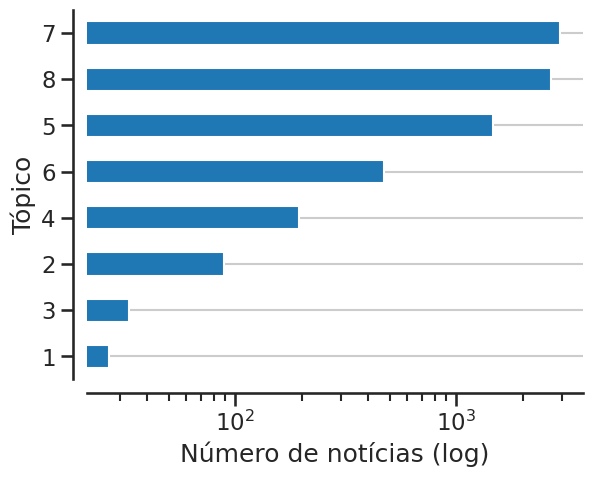

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
with sns.axes_style("ticks"):
    sns.set_context("talk")
    ax = news_2016['topic'].value_counts().sort_values().plot(kind = 'barh')
    ax.yaxis.grid(True)
    ax.set_ylabel("Tópico")
    ax.set_xlabel("Número de notícias (log)")
    sns.despine(offset = 10)
    ax.set_xscale("log")

## Crie uma nuvem de palavra para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa. 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cm

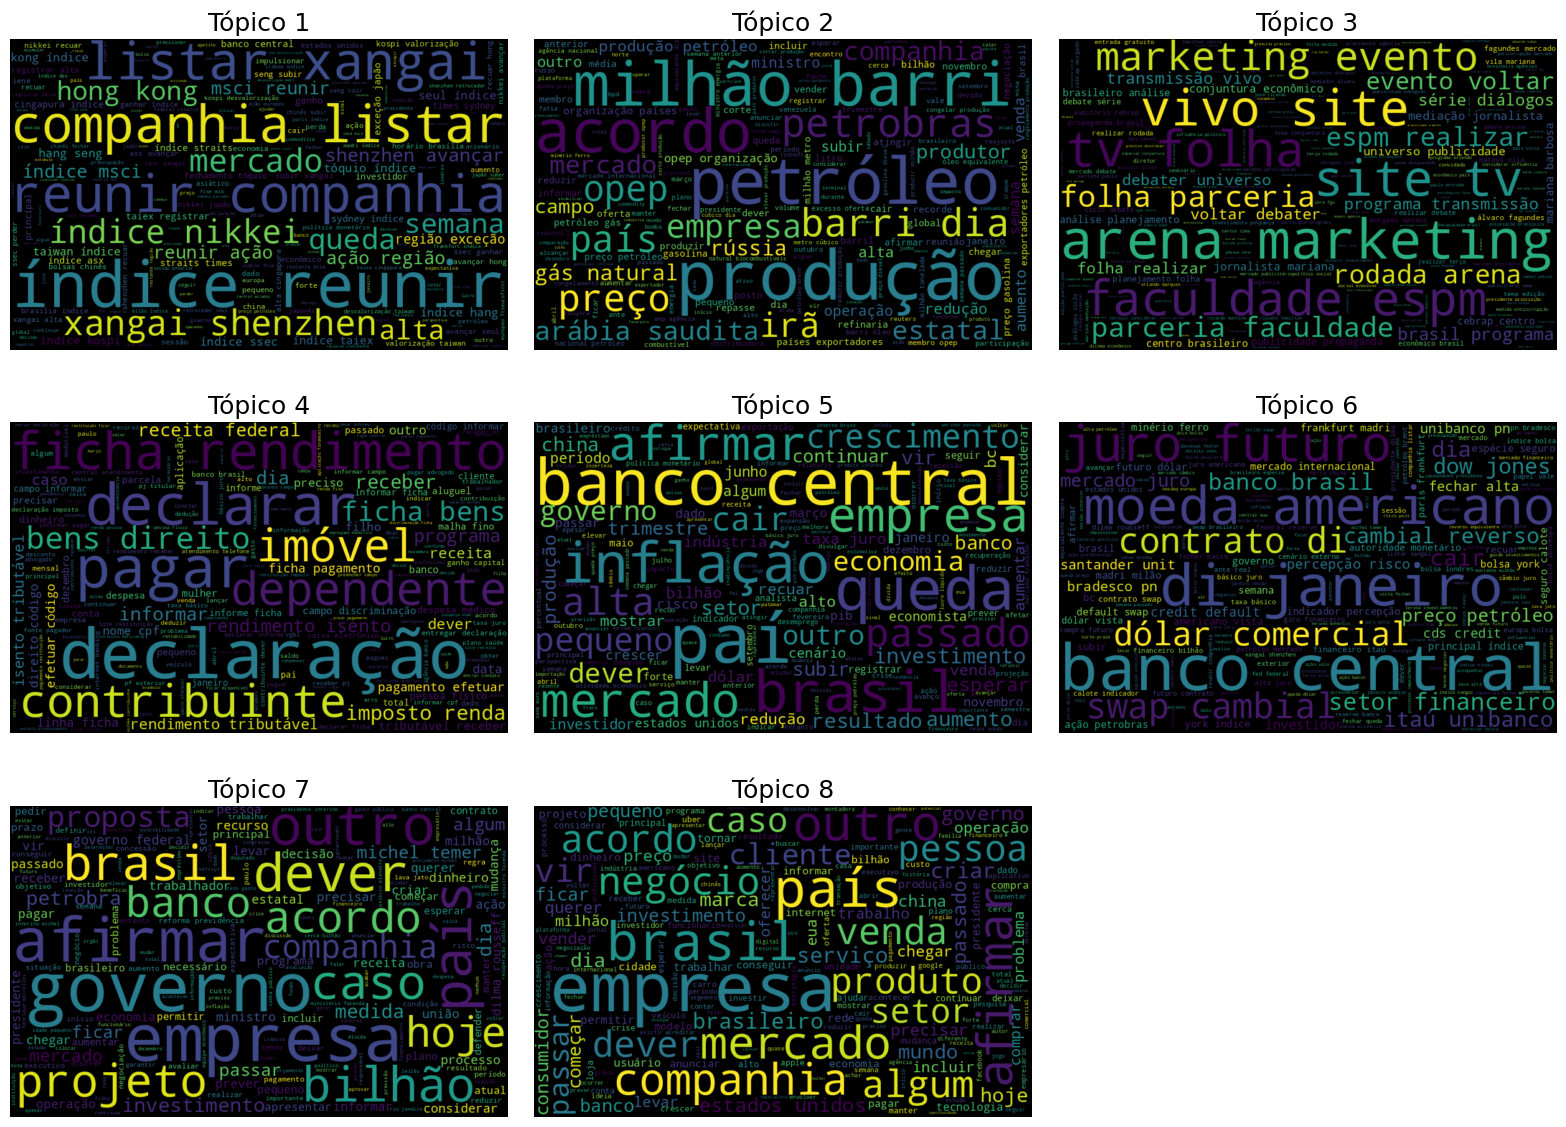

In [ ]:
def plot_wordcloud(text:str, ax:plt.Axes) -> plt.Axes:
    """
    Plot the wordcloud for the text/
    Arguments:
        -  text: string to be analised
        -  ax: plt subaxis
    Returns:
     - ax
    """
    wordcloud = WordCloud(width = 800, height = 500, random_state = 21
                          ,max_font_size = 110).generate(text)

    ax.imshow(wordcloud,interpolation = 'bilinear')
    ax.axis('off')
    return ax
    
def plot_wordcloud_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_words = chain(*topic_news.spacy_lemma.values.tolist())
    string_complete = ' '.join(list_of_words)
    if not string_complete:
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()

## Crie uma nuvem de entidades para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa. 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cm

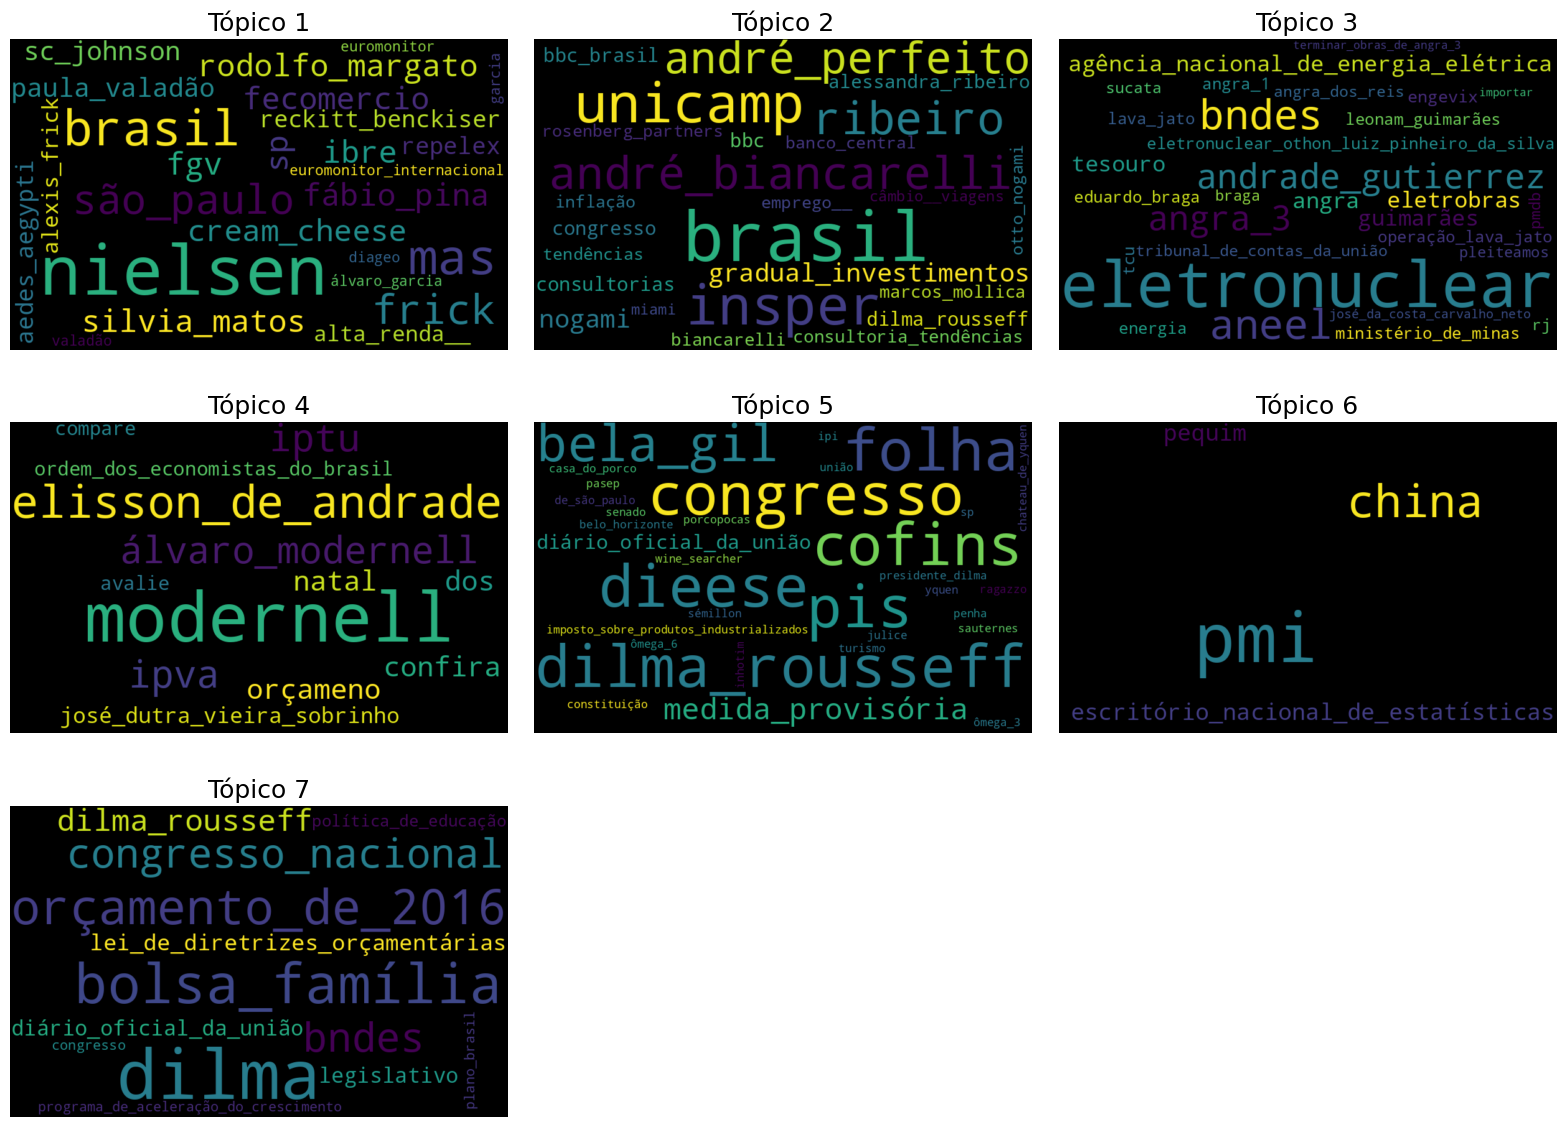

In [ ]:
def plot_wordcloud_entities_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_docs = topic_news.spacy_ner.apply(lambda l : [w.replace(" ", "_") for w in l])
    list_of_words = chain(*list_of_docs)
    string_complete = ' '.join(list_of_words)
    if not len(string_complete):
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_entities_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()